In [2]:
%matplotlib inline
import os

from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt

In [3]:
data_path = '../data/coco128'
data_type = 'train2017'
ann_path = '{}/annotations/instances_{}.json'.format(data_path, data_type)
img_path = '{}/images/{}'.format(data_path, data_type)

def get_img_path(img_id):
    return os.path.join(img_path, '{:012d}.jpg'.format(img_id))

In [26]:
coco = COCO(ann_path)

loading annotations into memory...
Done (t=17.95s)
creating index...
index created!


In [34]:
# display COCO categories and supercategories
cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
print('COCO categories: \n{}\n'.format(' '.join(nms)))

nms = set([cat['supercategory'] for cat in cats])
print('COCO supercategories: \n{}'.format(' '.join(nms)))

COCO categories: 
person bicycle car motorcycle airplane bus train truck boat traffic light fire hydrant stop sign parking meter bench bird cat dog horse sheep cow elephant bear zebra giraffe backpack umbrella handbag tie suitcase frisbee skis snowboard sports ball kite baseball bat baseball glove skateboard surfboard tennis racket bottle wine glass cup fork knife spoon bowl banana apple sandwich orange broccoli carrot hot dog pizza donut cake chair couch potted plant bed dining table toilet tv laptop mouse remote keyboard cell phone microwave oven toaster sink refrigerator book clock vase scissors teddy bear hair drier toothbrush

COCO supercategories: 
furniture accessory electronic animal food indoor kitchen person sports outdoor appliance vehicle


In [35]:
# get all images containing given categories, select one at random
catIds = coco.getCatIds(catNms=nms)
print(f'{catIds=}')
imgIds = coco.getImgIds(catIds=catIds)
print(f'{imgIds[:10]=}')

valid_imgIds = [imgId for imgId in imgIds if os.path.exists(get_img_path(imgId))]
print(f'{valid_imgIds[:10]=}')

catIds=[1]
imgIds[:10]=[262145, 262146, 524291, 262148, 393223, 393224, 524297, 393227, 131084, 393230]
valid_imgIds[:10]=[36, 49, 61, 74, 77, 86, 109, 110, 113, 127]


img={'license': 1, 'file_name': '000000000109.jpg', 'coco_url': 'http://images.cocodataset.org/train2017/000000000109.jpg', 'height': 416, 'width': 640, 'date_captured': '2013-11-22 08:45:41', 'flickr_url': 'http://farm8.staticflickr.com/7310/8716244332_8c77779378_z.jpg', 'id': 109}


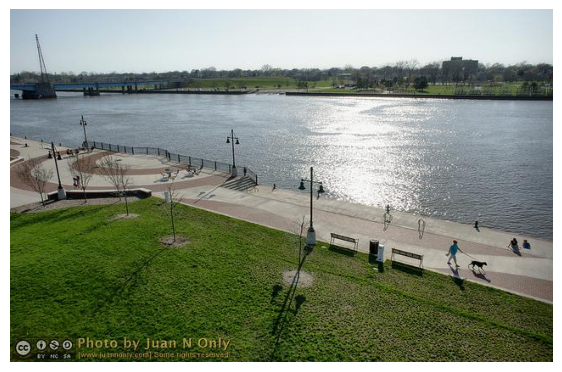

In [29]:
plt.figure(figsize=(7, 7))
# plot image: 322
imgId = 109
img = coco.loadImgs(imgId)[0]
print(f'{img=}')
I = io.imread(os.path.join(data_path, 'images', data_type, img['file_name']))
plt.axis('off')
plt.imshow(I)
plt.show()

annIds=[189352, 190838, 197534, 1239923, 2151449]
anns=[{'segmentation': [[514.61, 298.98, 517.05, 295.11, 518.2, 291.23, 517.91, 289.65, 515.33, 292.67, 514.75, 291.66, 512.89, 291.23, 513.03, 289.65, 514.32, 287.93, 516.47, 287.93, 516.47, 283.62, 519.78, 278.03, 521.93, 275.73, 521.78, 272.57, 522.79, 271.42, 525.66, 272.28, 526.95, 273.15, 527.67, 274.87, 526.95, 277.6, 528.67, 280.04, 529.1, 281.04, 534.13, 285.92, 532.98, 287.79, 528.24, 283.34, 525.8, 288.36, 525.8, 289.79, 526.52, 292.09, 527.38, 300.99, 530.25, 302.57, 530.11, 304.15, 524.51, 304.0, 524.51, 300.7, 522.93, 298.84, 521.78, 293.38, 518.77, 295.97, 518.34, 297.54, 521.5, 300.7, 520.21, 301.42, 514.46, 300.27]], 'area': 290.2648999999999, 'iscrowd': 0, 'image_id': 109, 'bbox': [512.89, 271.42, 21.24, 32.73], 'category_id': 1, 'id': 189352}, {'segmentation': [[597.48, 271.64, 597.6, 273.84, 598.33, 277.5, 598.94, 279.09, 599.8, 285.07, 603.22, 288.73, 604.07, 290.56, 601.02, 291.17, 600.04, 290.19, 595.04, 287.27, 5

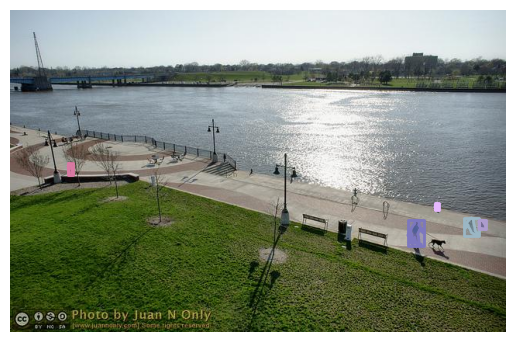

In [30]:
# load and display instance annotations
plt.imshow(I); plt.axis('off')
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
print(f'{annIds=}')
anns = coco.loadAnns(annIds)
print(f'{anns=}')
coco.showAnns(anns, draw_bbox=True)

In [7]:
# Make dataset for pytorch, based on coco dataset
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class CocoDataset(Dataset):
    def __init__(self, data_path, data_type, transform=None):
        self.data_path = data_path
        self.data_type = data_type
        self.transform = transform
        self.coco = COCO('{}/annotations/instances_{}.json'.format(data_path, data_type))

        # display COCO categories and supercategories
        cats = self.coco.loadCats(self.coco.getCatIds())
        nms=[cat['name'] for cat in cats]
        nms = set([cat['supercategory'] for cat in cats])
        # get all images containing given categories, select one at random
        catIds = self.coco.getCatIds(catNms=nms)
        imgIds = self.coco.getImgIds(catIds=catIds)


        self.catIds = catIds
        self.imgIds = [imgId for imgId in imgIds if os.path.exists(get_img_path(imgId))]
        self.cat2idx = {cat: idx for idx, cat in enumerate(self.catIds)}

    def __len__(self):
        return len(self.imgIds)

    def __getitem__(self, idx):
        imgId = self.imgIds[idx]
        img = self.coco.loadImgs(imgId)[0]
        annIds = self.coco.getAnnIds(imgIds=img['id'], catIds=self.catIds, iscrowd=None)
        anns = self.coco.loadAnns(annIds)

        img_path = os.path.join(self.data_path, 'images', self.data_type, img['file_name'])
        I = io.imread(img_path)
        if self.transform:
            I = self.transform(I)

        return I, anns

class CocoDataloader(DataLoader):
    def __init__(self, dataset, batch_size=1, shuffle=False, num_workers=0, transform=None):
        self.dataset = dataset
        super().__init__(self.dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return self.dataset[idx]



In [8]:
# Test dataloader
transform = transforms.Compose([
])
dataset = CocoDataset(data_path, data_type, transform=transform)
dataloader = CocoDataloader(dataset, batch_size=1, shuffle=True, num_workers=0)
print(f'{len(dataloader)=}')


loading annotations into memory...
Done (t=10.37s)
creating index...
index created!
len(dataloader)=61


TypeError: Invalid shape (3, 446, 640) for image data

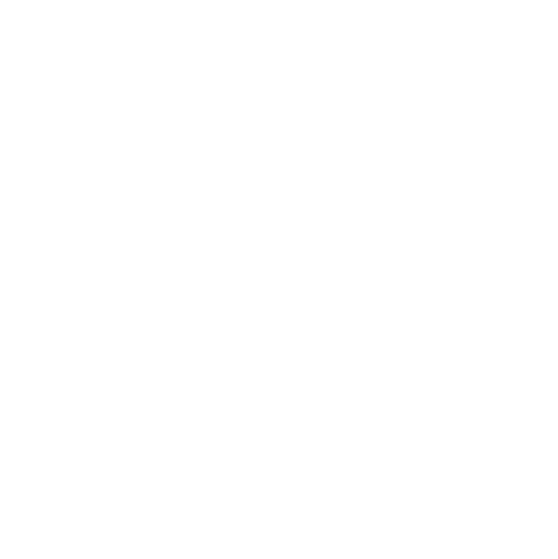

In [11]:
plt.figure(figsize=(7, 7))
I, anns = next(iter(dataloader))
plt.axis('off')
plt.imshow(I[0])
plt.show()
